# Uni-Mol Molecular Property Prediction

**Licenses**

Copyright (c) DP Technology.

This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.

**Citations**

Please cite the following papers if you use this notebook:

- Gengmo Zhou, Zhifeng Gao, Qiankun Ding, Hang Zheng, Hongteng Xu, Zhewei Wei, Linfeng Zhang, Guolin Ke. "[Uni-Mol: A Universal 3D Molecular Representation Learning Framework.](https://chemrxiv.org/engage/chemrxiv/article-details/6318b529bada388485bc8361)"
ChemRxiv (2022)

## Data Preparation (SMILES, label to .lmdb)

In [96]:
import os
import lmdb
import pickle
import time
import pandas as pd
import numpy as np
from rdkit import Chem
from tqdm import tqdm
from rdkit.Chem import AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  
import warnings
warnings.filterwarnings(action='ignore')
from multiprocessing import Pool


## Finetuning (based on pretraining)

In [97]:
date_str = time.strftime("%m%d-%y", time.localtime())

data_path='./'  # replace to your data path
save_dir=f"./save_4CR_{date_str}"  # replace to your save path
MASTER_PORT=10086
n_gpu=1
dict_name='dict.txt'
# weight_path='./weights/mol_pre_no_h_220816.pt'  # replace to your ckpt path, 0.81 when using unimol layers
# weight_path='/fs01/datasets/cellxgene/3d_molecule_save/pretrain-20240502-2040/checkpoint_best.pt'  # on 12 hour training, 0.75 when using unimol layers; 15h 0.77 on a100; 0.72 using pytorch layernorm; 18h 0.80 on a100
weight_path="/home/pangkuan/dev/SDL-LNP/model/evaluation/notebooks/model_weight/mol_pre_no_h_220816.pt"  # on 15 hour training, 0.82 when using unimol layers; 18h 0.84 on a100; 21h 0.82 on a100; 0.84 using pytorch softmax
# weight_path = "/home/pangkuan/dev/SDL-LNP/model/evaluation/notebooks/model_weight/customized_model/checkpoint_best.pt"
# weight_path='/fs01/datasets/cellxgene/3d_molecule_save/pretrain-20240503-2035/checkpoint_best.pt'
# task_name='4CR'  # data folder name
task_name="4CR_customized"
task_num=1
loss_func='finetune_rank'
lr=1e-4
batch_size = local_batch_size=  8 #64
epoch=60
dropout=0.0
warmup=0.06 # 0.06
# local_batch_size=64
only_polar=0 # -1 all h; 0 no h
conf_size=11
seed=0
metric="valid_agg_rmse"
update_freq=batch_size / local_batch_size

# !python -m torch.distributed.launch --nproc_per_node=$n_gpu --master_port=$MASTER_PORT $(which unicore-train) $data_path --task-name $task_name --user-dir ../unimol --train-subset train --valid-subset valid \

# remove the save_dir if exists
if os.path.exists(save_dir):
    os.system(f"rm -rf {save_dir}")

# !cp ../example_data/molecule/$dict_name $data_path
!export NCCL_ASYNC_ERROR_HANDLING=1
!export OMP_NUM_THREADS=1
!python $(which unicore-train) $data_path --task-name $task_name --user-dir ../unimol --train-subset train --valid-subset valid \
       --conf-size $conf_size \
       --num-workers 6 --ddp-backend=c10d \
       --dict-name $dict_name \
       --task mol_finetune --loss $loss_func --arch unimol_base  \
       --classification-head-name $task_name --num-classes $task_num \
       --optimizer adam --adam-betas '(0.9, 0.99)' --adam-eps 1e-6 --clip-norm 1.0 \
       --lr-scheduler polynomial_decay --lr $lr --warmup-ratio $warmup --max-epoch $epoch --batch-size $local_batch_size --pooler-dropout $dropout\
       --update-freq $update_freq --seed $seed \
       --fp16 --fp16-init-scale 4 --fp16-scale-window 256 \
       --log-interval 100 --log-format simple \
       --validate-interval 1 --keep-last-epochs 1 \
       --finetune-from-model $weight_path \
       --best-checkpoint-metric $metric --patience 20 \
       --save-dir $save_dir --only-polar $only_polar \
       # --maximize-best-checkpoint-metric
# --maximize-best-checkpoint-metric, for classification task

# # optional layers
# fused_multi_tensor, probably not really used
# fused_rounding, probably not really used
# fused_layer_norm, tested seems useful
# fused_softmax, tested seems only sometimes useful

2024-05-08 17:17:21 | INFO | unicore_cli.train | Namespace(no_progress_bar=False, log_interval=100, log_format='simple', tensorboard_logdir='', wandb_project='', wandb_name='', seed=0, cpu=False, fp16=True, bf16=False, bf16_sr=False, allreduce_fp32_grad=False, fp16_no_flatten_grads=False, fp16_init_scale=4, fp16_scale_window=256, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir='../unimol', empty_cache_freq=0, all_gather_list_size=16384, suppress_crashes=False, profile=False, ema_decay=-1.0, validate_with_ema=False, loss='finetune_rank', optimizer='adam', lr_scheduler='polynomial_decay', task='mol_finetune', num_workers=6, skip_invalid_size_inputs_valid_test=False, batch_size=8, required_batch_size_multiple=1, data_buffer_size=10, train_subset='train', valid_subset='valid', validate_interval=1, validate_interval_updates=0, validate_after_updates=0, fixed_validation_seed=None, disable_validation=False, batch_size_valid=8, max_valid_steps=None, curricu

## Inference

In [98]:
results_path=f"./infer_4CR_{date_str}"  # replace to your results path
weight_path=f"./save_4CR_{date_str}/checkpoint_best.pt"  # replace to your ckpt path
# batch_size=64
# task_name='4CR' # data folder name 
# task_num=1
# loss_func='finetune_mse'
# dict_name='dict.txt'
# conf_size=11
# only_polar=0

!cp ../example_data/molecule/$dict_name $data_path
!CUDA_VISIBLE_DEVICES="0" python ../unimol/infer.py --user-dir ../unimol $data_path --task-name $task_name --valid-subset test \
       --results-path $results_path \
       --num-workers 6 --ddp-backend=c10d --batch-size $batch_size \
       --task mol_finetune --loss $loss_func --arch unimol_base \
       --classification-head-name $task_name --num-classes $task_num \
       --dict-name $dict_name --conf-size $conf_size \
       --only-polar $only_polar  \
       --path $weight_path  \
       --fp16 --fp16-init-scale 4 --fp16-scale-window 256 \
       --log-interval 50 --log-format simple 

cp: cannot stat '../example_data/molecule/dict.txt': No such file or directory


2024-05-08 17:20:39 | INFO | unimol.inference | loading model(s) from ./save_4CR_0508-24/checkpoint_best.pt
2024-05-08 17:20:40 | INFO | unimol.tasks.unimol_finetune | dictionary: 30 types
2024-05-08 17:20:40 | INFO | unimol.inference | Namespace(no_progress_bar=False, log_interval=50, log_format='simple', tensorboard_logdir='', wandb_project='', wandb_name='', seed=1, cpu=False, fp16=True, bf16=False, bf16_sr=False, allreduce_fp32_grad=False, fp16_no_flatten_grads=False, fp16_init_scale=4, fp16_scale_window=256, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir='../unimol', empty_cache_freq=0, all_gather_list_size=16384, suppress_crashes=False, profile=False, ema_decay=-1.0, validate_with_ema=False, loss='finetune_rank', optimizer='adam', lr_scheduler='fixed', task='mol_finetune', num_workers=6, skip_invalid_size_inputs_valid_test=False, batch_size=8, required_batch_size_multiple=1, data_buffer_size=10, train_subset='train', valid_subset='test', vali

## Read inference results (.pkl to .csv)

In [99]:

def get_csv_results(predict_path, csv_path):
    predict = pd.read_pickle(predict_path)
    smi_list, predict_list = [], []
    target_list = []
    for batch in predict:
        sz = batch["bsz"]
        for i in range(sz):
            smi_list.append(batch["smi_name"][i])
            predict_list.append(batch["predict"][i][0].cpu().tolist())
            target_list.append(batch["target"][i][0].cpu().tolist())
    predict_df = pd.DataFrame({"SMILES": smi_list, "predict": predict_list, "target": target_list})
    predict_df = predict_df.groupby("SMILES").mean().reset_index()
    predict_df.to_csv(csv_path,index=False)
    return predict_df

predict_path=f"./infer_4CR_{date_str}/save_4CR_{date_str}_test.out.pkl"  # replace to your results path
csv_path=f"./infer_4CR_{date_str}/4CR_results.csv"
predict_df = get_csv_results(predict_path, csv_path)
predict_df.info(), predict_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SMILES   192 non-null    object 
 1   predict  192 non-null    float64
 2   target   192 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.6+ KB


(None,
                                               SMILES   predict    target
 0  CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NC(C)(C)C...  0.677335 -5.523562
 1  CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NC(C)(C)C...  0.537265 -1.938599
 2  CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NC12C[C@H...  0.447565 -0.823122
 3  CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NC1CCCCC1...  0.150039 -0.665581
 4  CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NCC(=O)OC...  0.277866 -0.353637)

In [100]:
predict_df

,SMILES,predict,target
0,CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NC(C)(C)C...,0.677335,-5.523562
1,CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NC(C)(C)C...,0.537265,-1.938599
2,CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NC12C[C@H...,0.447565,-0.823122
3,CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NC1CCCCC1...,0.150039,-0.665581
4,CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C(=O)NCC(=O)OC...,0.277866,-0.353637
...,...,...,...
187,CCCCCCCCCCCC(=O)OCCCCCN(C(N(C)C)C(=O)NC(C)(C)C...,0.940918,-0.314109
188,CCCCCCCCCCCC(=O)OCCCCCN(C(N(C)C)C(=O)NC12C[C@H...,0.888450,-5.523562
189,CCCCCCCCCCCC(=O)OCCCCCN(C(N(C)C)C(=O)NC1CCCCC1...,1.299494,0.605721
190,CCCCCCCCCCCC(=O)OCCCCCN(C(N(C)C)C(=O)NCC(=O)OC...,0.828924,1.031027


In [101]:
# compute the pearson correlation coefficient between predict and target
from scipy.stats import pearsonr
pearson_corr = pearsonr(predict_df["predict"], predict_df["target"])[0]
print("pearsonr: ", pearson_corr)

pearsonr:  0.7992480855647353


In [102]:
# check spearman correlation
from scipy.stats import spearmanr
spearman_corr = spearmanr(predict_df["predict"], predict_df["target"])[0]
print("spearmanr: ", spearman_corr)

spearmanr:  0.8015013725195688


Top 10 predicted smiles: 


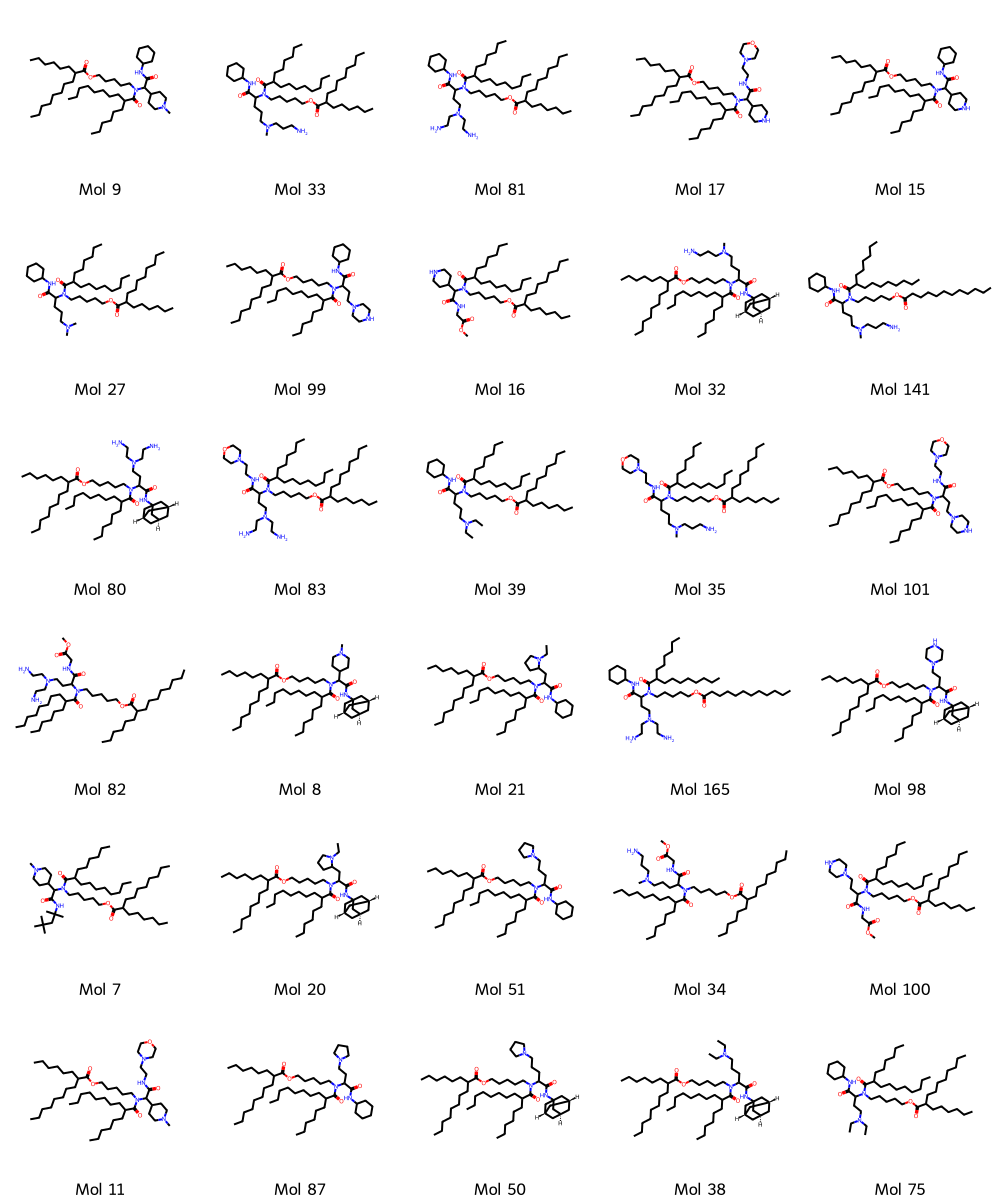

['CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C1CCN(C)CC1)C(=O)NC1CCCCC1)C(=O)C(CCCCCC)CCCCCCCC'
 'CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(CCCN(C)CCCN)C(=O)NC1CCCCC1)C(=O)C(CCCCCC)CCCCCCCC'
 'CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(CCN(CCN)CCN)C(=O)NC1CCCCC1)C(=O)C(CCCCCC)CCCCCCCC'
 'CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C1CCNCC1)C(=O)NCCN1CCOCC1)C(=O)C(CCCCCC)CCCCCCCC'
 'CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C1CCNCC1)C(=O)NC1CCCCC1)C(=O)C(CCCCCC)CCCCCCCC'
 'CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(CCCN(C)C)C(=O)NC1CCCCC1)C(=O)C(CCCCCC)CCCCCCCC'
 'CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(CCN1CCNCC1)C(=O)NC1CCCCC1)C(=O)C(CCCCCC)CCCCCCCC'
 'CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(C1CCNCC1)C(=O)NCC(=O)OC)C(=O)C(CCCCCC)CCCCCCCC'
 'CCCCCCCCC(CCCCCC)C(=O)OCCCCCN(C(CCCN(C)CCCN)C(=O)NC12C[C@H]3C[C@H](C[C@H](C3)C1)C2)C(=O)C(CCCCCC)CCCCCCCC'
 'CCCCCCCCCCCC(=O)OCCCCCN(C(CCCN(C)CCCN)C(=O)NC1CCCCC1)C(=O)C(CCCCCC)CCCCCCCC']


In [103]:
# rank the predict_df by predict value
predict_df_sort = predict_df.sort_values(by="predict", ascending=False)
predict_df_sort.to_csv(f"./infer_4CR_{date_str}/4CR_results_sort.csv", index=False)

# visualize the first 10 smiles in the SIMILES column
from rdkit.Chem import Draw

print("Top 10 predicted smiles: ")
img = Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in predict_df_sort["SMILES"].values[:30]], molsPerRow=5, legends=[f"Mol {id}" for id in predict_df_sort["SMILES"].index[:30]])
display(img)
print(predict_df_sort["SMILES"].values[:10])

Least 10 predicted smiles: 


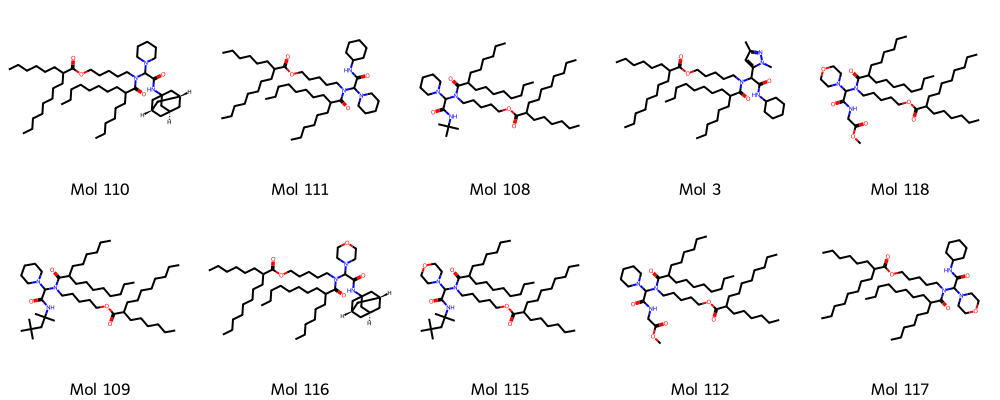

In [104]:
print("Least 10 predicted smiles: ")
img = Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in predict_df_sort["SMILES"].values[-10:]], molsPerRow=5, legends=[f"Mol {id}" for id in predict_df_sort["SMILES"].index[-10:]])
display(img)

Top 10 experiment smiles: 


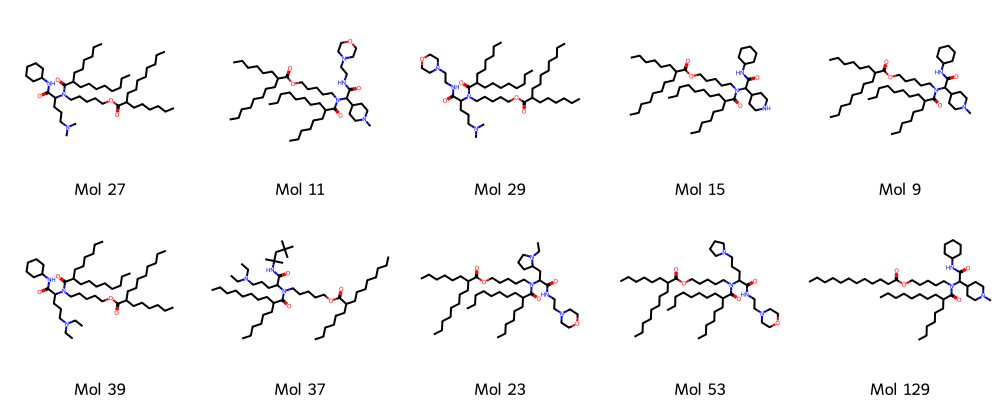

In [105]:
# visualize the first 10 smiles in the SIMILES column
from rdkit.Chem import Draw

print("Top 10 experiment smiles: ")
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in predict_df.sort_values(by="target", ascending=False)["SMILES"].values[:10]], molsPerRow=5, legends=[f"Mol {id}" for id in predict_df.sort_values(by="target", ascending=False)["SMILES"].index[:10]])